## Power atlas and ABIDE connectivity mapping

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import networkx as nx
import numpy as np
from nilearn import plotting
%matplotlib inline
from nilearn import datasets
%load_ext autoreload
%autoreload 2

/Users/irinaknyazeva/opt/anaconda3/envs/brain/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
import sys
sys.path.append('../benchmark_rsfMRI_prediction/')
from connectome_matrices import ConnectivityMeasure
from sklearn.covariance import LedoitWolf
import pickle


In [2]:
power = datasets.fetch_coords_power_2011()
print('Power atlas comes with {0}.'.format(power.keys()))

Power atlas comes with dict_keys(['rois', 'description']).


In [4]:
power.rois[0]

(1, -25, -98, -12)

In [4]:
print(power.description)


b'Power 2011 atlas\n\n\nNotes\n-----\n264 ROIs obtained by meta-analysis.\n\n\nContent\n-------\n    :\'rois\': Coordinates of ROIs in MNI space.\n\n\nReferences\n----------\nPower, Jonathan D., et al. "Functional network organization of the human\nbrain." Neuron 72.4 (2011): 665-678.\n'


In [5]:
pheno_abide_path = '../benchmark_rsfMRI_prediction/Phenotypic_V1_0b_preprocessed1.csv'
abide_dir = '../benchmark_rsfMRI_prediction/Data/ABIDE'
atlas = 'Power'
pheno_abide = pd.read_csv(pheno_abide_path, usecols = [i for i in range(4,15)])
pheno_abide.head()

,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,VIQ
0,50002,PITT,no_filename,1,1,16.77,1,Ambi,NaN,103.0,116.0
1,50003,PITT,Pitt_0050003,1,1,24.45,1,R,NaN,124.0,128.0
2,50004,PITT,Pitt_0050004,1,1,19.09,1,R,NaN,113.0,108.0
3,50005,PITT,Pitt_0050005,1,1,13.73,2,R,NaN,119.0,117.0
4,50006,PITT,Pitt_0050006,1,1,13.37,1,L,NaN,109.0,99.0


In [6]:
def read_abide_data(phenotypes, atlas, timeseries_dir):
    timeseries = []
    IDs_subject = []
    diagnosis = []
    subids = phenotypes['subject']
    for subj_id in subids:
        this_pheno = phenotypes[phenotypes['subject'] == subj_id]
        this_timeseries = os.path.join(timeseries_dir, atlas, str(subj_id) + '_timeseries.txt')
        if os.path.exists(this_timeseries):
            timeseries.append(np.loadtxt(this_timeseries))
            IDs_subject.append(subj_id)
            diagnosis.append(this_pheno['DX_GROUP'].values[0])
    return timeseries, diagnosis, IDs_subject

Будем здесь использовать только корреляции и частные корреляции, 
потому что из касательного пространства сложно потом перейти к матрицам смежности и сетям. Диагонали не нулевые и куча гемора.

In [8]:
measures = ['correlation', 'partial correlation']
abide_series, abide_diagnosis, abide_subject_ids = read_abide_data(pheno_abide, atlas, abide_dir)

In [62]:
del abide_series

In [9]:
conn_abide = {}
for measure in measures:
    connections = ConnectivityMeasure(cov_estimator=LedoitWolf(assume_centered=True),
                    kind=measure)
    conn_coefs = connections.fit_transform(abide_series, vectorize=True)
    conn_abide[measure] = conn_coefs
conn_abide['abide_diagnosis'] = abide_diagnosis
conn_abide['abide_subject_ids'] = abide_subject_ids  

In [10]:
with open('power_conn_abide.pickle', 'wb') as handle:
    pickle.dump(conn_abide, handle, protocol=pickle.DEFAULT_PROTOCOL)

In [8]:
with open('power_conn_abide.pickle', 'rb') as handle:
    conn_abide = pickle.load(handle)
print(conn_abide.keys())    

dict_keys(['correlation', 'partial correlation', 'abide_diagnosis', 'abide_subject_ids'])


In [9]:
def vec_to_sym(vec, Nnodes = 264):
    tril_mask = np.tril(np.ones((Nnodes, Nnodes)), k=-1).astype(bool)
    sym = np.zeros((vec.shape[0], Nnodes, Nnodes))
    sym[:,tril_mask] = vec
    return sym + np.transpose(sym, axes = (0,2,1))
    

In [10]:
corr_abide = vec_to_sym(conn_abide['correlation'])
pcorr_abide = vec_to_sym(conn_abide['partial correlation'])

1 - Autism, 2-Control
http://fcon_1000.projects.nitrc.org/indi/abide/ABIDEII_Data_Legend.pdf

In [11]:
from nilearn import plotting

In [12]:
aut_indx = np.where(np.array(conn_abide['abide_diagnosis'])==1)[0]
cont_indx = np.where(np.array(conn_abide['abide_diagnosis'])==2)[0]

In [13]:
corr_aut = corr_abide[aut_indx,:,:].mean(axis=0)
corr_cont =  corr_abide[cont_indx,:,:].mean(axis=0)
pcorr_aut = pcorr_abide[aut_indx,:,:].mean(axis=0)
pcorr_cont = pcorr_abide[cont_indx,:,:].mean(axis=0)

In [14]:
coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T

print('Stacked power coordinates in array of shape {0}.'.format(coords.shape))

Stacked power coordinates in array of shape (264, 3).


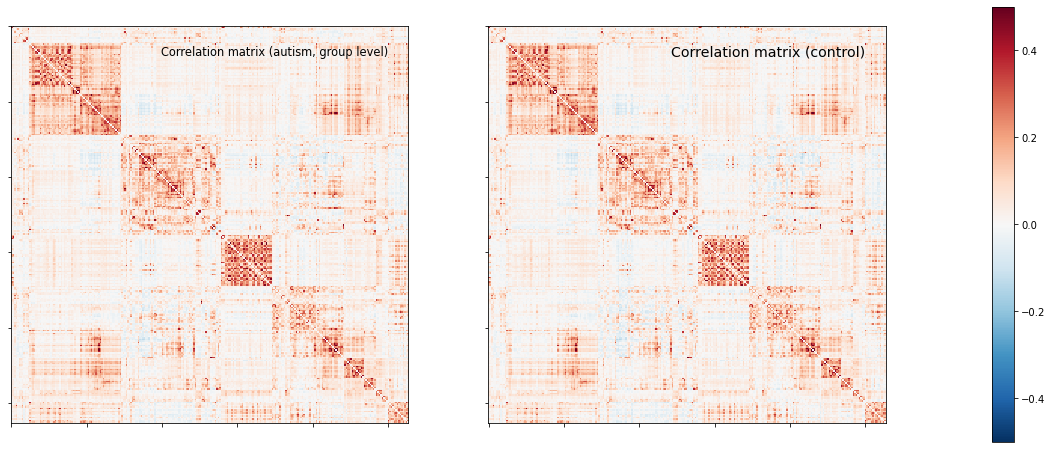

In [15]:
fig, axs = plt.subplots(1,2, figsize = (18,10))  
plotting.plot_matrix(corr_aut, vmin=-0.5, vmax=0.5, colorbar=False, axes= axs[0],
                     title='Correlation matrix (autism, group level)');
plotting.plot_matrix(corr_cont, vmin=-0.5, vmax=0.5, colorbar=True, axes= axs[1],
                     title='Correlation matrix (control)');

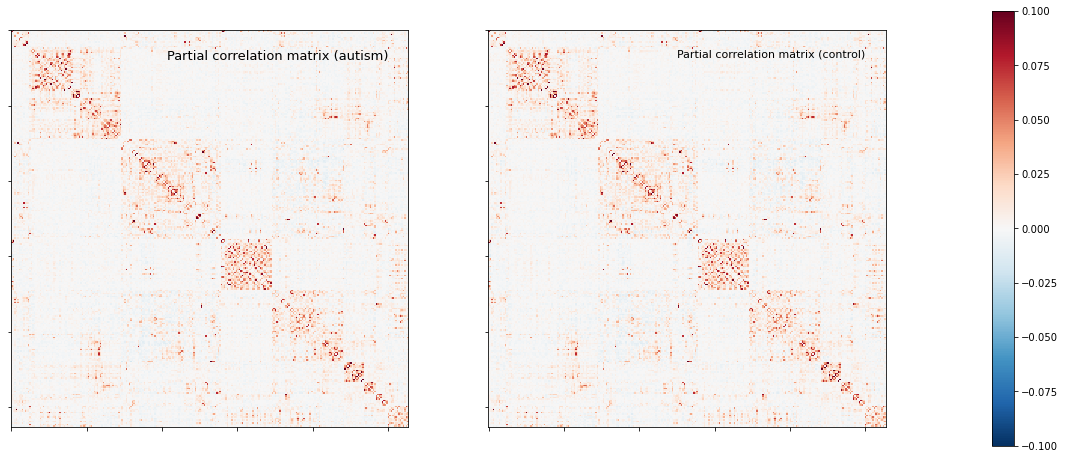

In [16]:
fig, axs = plt.subplots(1,2, figsize = (18,10))  
plotting.plot_matrix(pcorr_aut, vmin=-0.1, vmax=0.1, colorbar=False, axes= axs[0],
                     title='Partial correlation matrix (autism)');
plotting.plot_matrix(pcorr_cont, vmin=-0.1, vmax=0.1, colorbar=True, axes= axs[1],
                     title='Partial correlation matrix (control)');

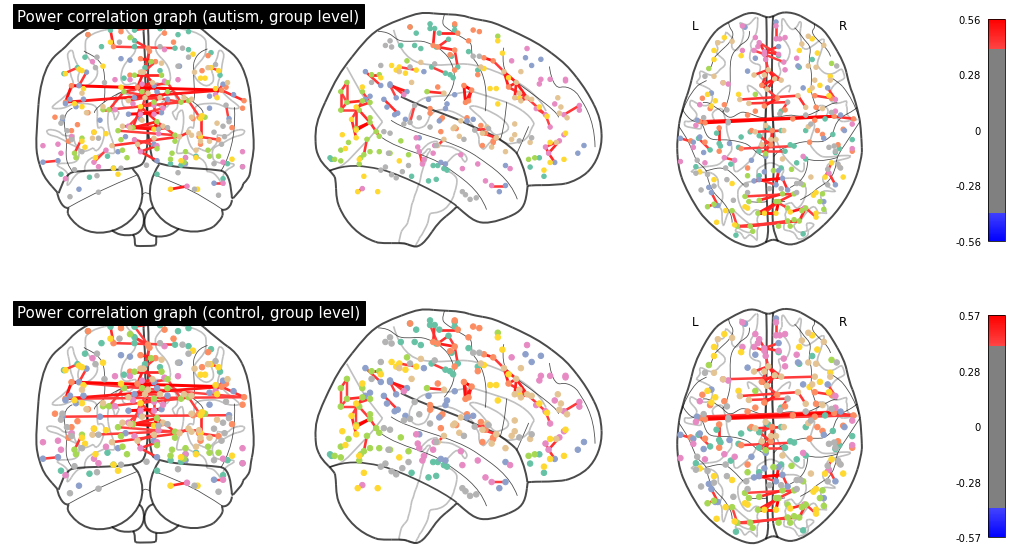

In [17]:
fig, axs = plt.subplots(2,1, figsize = (18,10))  

plotting.plot_connectome(corr_aut, coords, title='Power correlation graph (autism, group level)', axes = axs[0],
                         edge_threshold='99.8%', node_size=20, colorbar=True)

plotting.plot_connectome(corr_cont, coords, title='Power correlation graph (control, group level)', axes = axs[1],
                         edge_threshold='99.8%', node_size=30, colorbar=True)

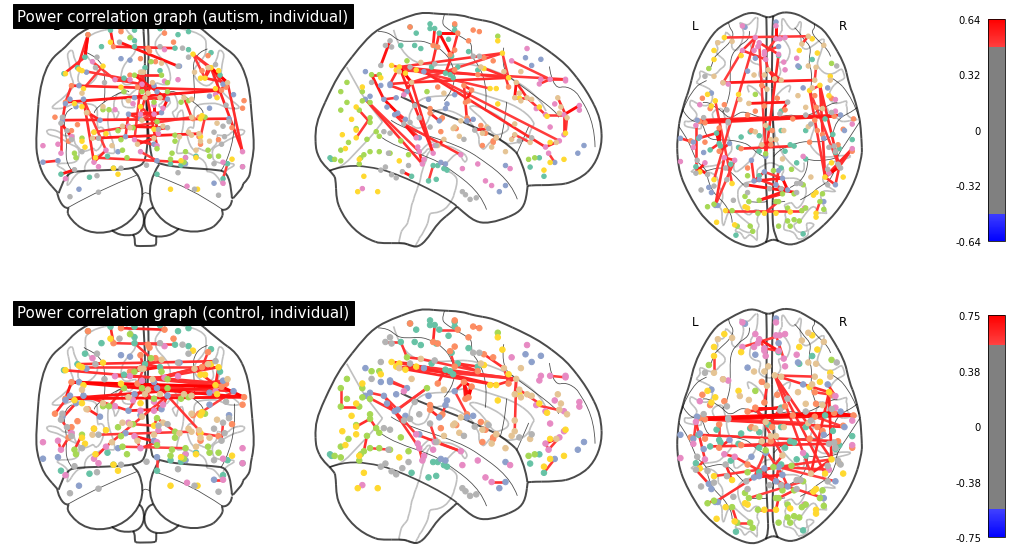

In [86]:
fig, axs = plt.subplots(2,1, figsize = (18,10))  

plotting.plot_connectome(corr_abide[aut_indx[1],:,:], coords, title='Power correlation graph (autism, individual)', axes = axs[0],
                         edge_threshold='99.8%', node_size=20, colorbar=True);

plotting.plot_connectome(corr_abide[cont_indx[1],:,:], coords, title='Power correlation graph (control, individual)', axes = axs[1],
                         edge_threshold='99.8%', node_size=30, colorbar=True);

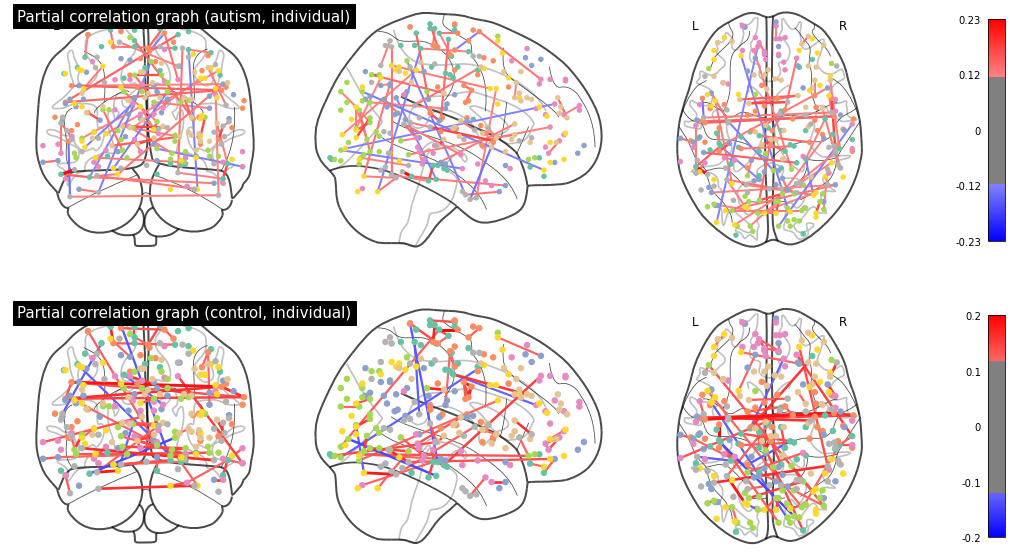

In [88]:
fig, axs = plt.subplots(2,1, figsize = (18,10))  

plotting.plot_connectome(pcorr_abide[aut_indx[1],:,:], coords, title='Partial correlation graph (autism, individual)', axes = axs[0],
                         edge_threshold='99.8%', node_size=20, colorbar=True);

plotting.plot_connectome(pcorr_abide[cont_indx[1],:,:], coords, title='Partial correlation graph (control, individual)', axes = axs[1],
                         edge_threshold='99.8%', node_size=30, colorbar=True);

In [95]:
from matplotlib.pyplot import cm

def plot_markers(matrix,coords, corr_type = 'correlation'): 
    # clip connectivity matrix to preserve positive and negative edges
    positive_edges = np.clip(matrix, 0, matrix.max())
    negative_edges = np.clip(matrix, matrix.min(), 0)

    # calculate strength for positive edges
    node_strength_positive = np.sum(np.abs(positive_edges), axis=0)
    node_strength_positive /= np.max(node_strength_positive)

    # calculate strength for negative edges
    node_strength_negative = np.sum(np.abs(negative_edges), axis=0)
    node_strength_negative /= np.max(node_strength_negative)

    # plot nodes' strength for positive edges
    plotting.plot_markers(
        node_strength_positive,
        coords,
        title=f'Node strength for the positive edges for {corr_type} matrix',
        node_cmap=cm.YlOrRd
    )

    # plot nodes' strength for negative edges
    plotting.plot_markers(
        node_strength_negative,
        coords,
        title=f'Node strength for the negative edges for {corr_type} matrix',
        node_cmap=cm.PuBu
    )

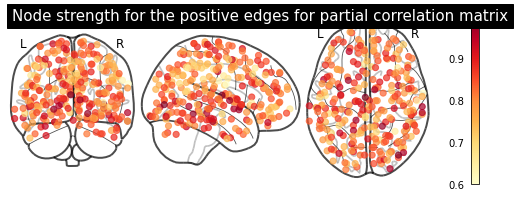

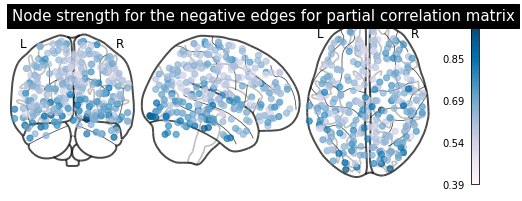

In [97]:
plot_markers(pcorr_abide[cont_indx[1],:,:],coords, corr_type = 'partial correlation'); 

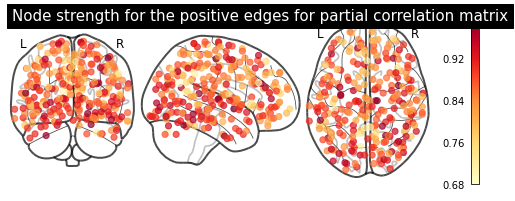

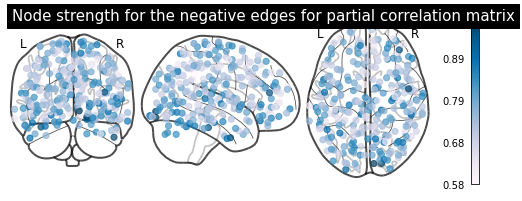

In [98]:
plot_markers(pcorr_abide[aut_indx[1],:,:],coords, corr_type = 'partial correlation'); 

In [ ]:
fig, axs = plt.subplots(2,1, figsize = (18,10))  

plotting.plot_connectome(corr_aut, coords, title='Power correlation graph (autism, group level)', axes = axs[0],
                         edge_threshold='99.8%', node_size=20, colorbar=True)

plotting.plot_connectome(corr_cont, coords, title='Power correlation graph (control, group level)', axes = axs[1],
                         edge_threshold='99.8%', node_size=30, colorbar=True)

## ML classification part

Согласно  Dadi и др., 2019 разница между протоколами не велика, в данном случае был выбран атлас в виде шариков, чтобы можно было хоть как-то визуализировать что получается. В качестве модели берем логистическую регрессию, потому что можно ее интерпретировать. 

In [188]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [19]:
_ , classes  = np.unique(conn_abide['abide_diagnosis'],return_inverse=True)

In [20]:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2,
                            random_state=0)

In [453]:
# Logistic Regression 'l1'
logreg_l1 = LogisticRegression(penalty='l1',dual=False, solver='liblinear',
                                      random_state=0)
# Logistic Regression 'l2'
logreg_weights = LogisticRegression(penalty='l2', C=10, solver='lbfgs', max_iter=400, random_state=0)

In [23]:
cross_val_score(logreg_l1,conn_abide['correlation'], classes, cv=cv, scoring = 'roc_auc')

array([0.66706491, 0.68339307, 0.70516395, 0.64542679, 0.6702509 ])

In [454]:
cross_val_score(logreg_weights,conn_abide['correlation'], classes, cv=cv, scoring = 'roc_auc')

array([0.69573875, 0.72135935, 0.72162485, 0.65976371, 0.72919156])

In [198]:
parameters = {'C':[10]}
grid_search = GridSearchCV(estimator=logreg_l2, param_grid=parameters, n_jobs=-1, cv=5, scoring='roc_auc',error_score=0)
grid_result = grid_search.fit(conn_abide['correlation'], classes)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.683756 using {'C': 10}


In [456]:
X_train, X_test, y_train, y_test = train_test_split(conn_abide['correlation'], classes, test_size=0.2)
logreg_weights.fit(conn_abide['correlation'], classes)
print(logreg_weights.score(X_test, y_test))
#logreg_weights.coef_.flatten()

1.0


In [26]:
logreg_weights.coef_.shape[0]

1

In [457]:
np.percentile(logreg_weights.coef_.flatten(), 90)

0.056975558370356325

In [458]:
conn_abide['correlation'][:,np.abs(logreg_weights.coef_.flatten())>0.08].shape

(866, 2538)

Вот эти параметры позволяют однозначно разделить выборку, можно посмотреть по каким критериям

In [27]:
coeffs_abide = vec_to_sym(logreg_l2.coef_)

In [28]:
coeffs_abide.shape

(1, 264, 264)

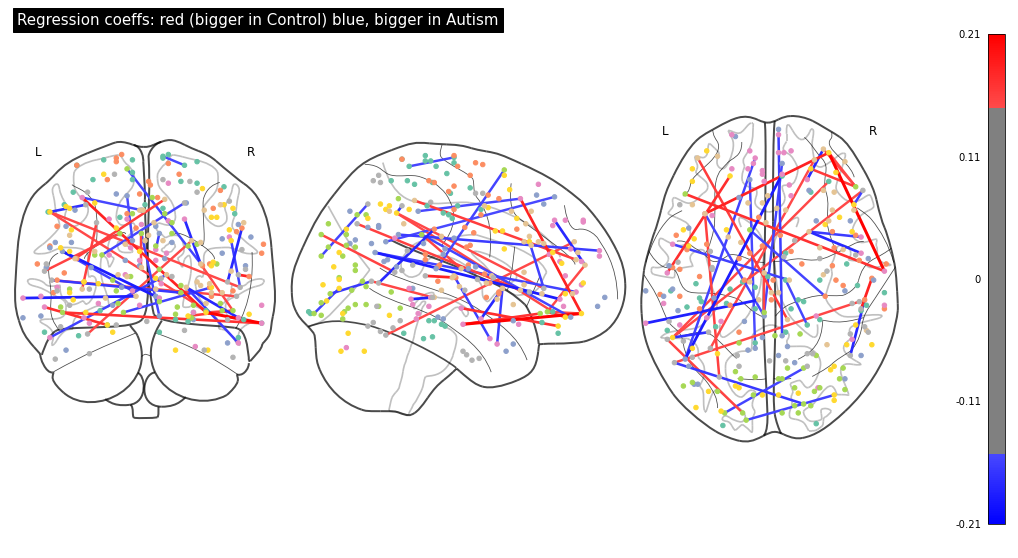

In [60]:
fig, ax = plt.subplots(1,1, figsize = (18,10)) 
plotting.plot_connectome(coeffs_abide[0,:,:], coords, title='Regression coeffs: red (bigger in Control) blue, bigger in Autism',
                         edge_threshold='99.9%', node_size=20, colorbar=True, axes = ax);


## Сетевые метрики
Посмотрели что можно сказать опираясь только на веса и не учитывая структуру. Можно посмотреть отдельно что может дать топология сети в целом и отдельно характеристики нодов. Здесь опять куча вариантов как это делать. Коэффициенты корреляции могут быть положительные и отрицательные, а вот работать с сетями со знаком сложно, поэтому рассматривают либо модуль, либо отдельно положительные и отрицательные корреляции. Посмотрим модуль веса и положительные корреляции, оставим только 10\% связей, посмотрим что можно напрогнозировать глобальными метриками и что node-based  

Выберем ноды, которые участвовали в формировании весов и показались наиболее значимыми в логистической регрессии

In [174]:
np.percentile(logreg_l2.coef_, 97.5)

0.08823532855198837

In [91]:
threshd = coeffs_abide*(np.abs(coeffs_abide)>0.16)*1
node_list = list(set(np.unique(np.where(np.abs(threshd)>0)[2])).union(np.unique(np.where(np.abs(threshd)>0)[1])))
print(len(node_list))

29


Взято отсюда: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0062867
Network properties can be defined globally, describing the structure of the entire network (e.g., assortativity coefficient [11], closeness centrality [12], characteristic path length [13], clustering coefficient [13], global efficiency [14], graph transitivity [15], local efficiency [14], modularity [16], small-worldness [17]). Or, they can be defined locally, on a per-node basis, so as to focus on neural regions of interest (e.g., node betweenness centrality [12], node degree/strength, node characteristic path length [13], node clustering coefficient [13] and node global and local efficiency [14].

### Сетевой анализ
матрица с положительными корреляциями, оставляем 10% связей

In [175]:
np.percentile(np.abs(conn_abide['correlation'])[:],[10,90])

array([0.01845055, 0.26540623])

In [110]:
corr_abide = vec_to_sym(conn_abide['correlation'])
corr_abide[corr_abide<0.25]=0

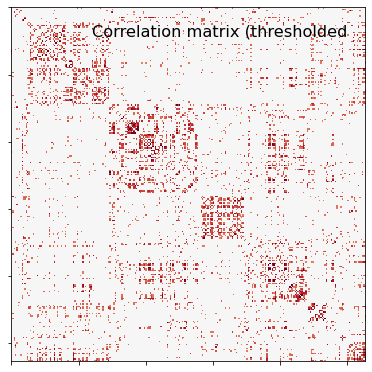

In [111]:
plotting.plot_matrix(corr_abide[1], vmin=-0.5, vmax=0.5, colorbar=False,
                     title='Correlation matrix (thresholded');

In [576]:
corr_abide = vec_to_sym(conn_abide['correlation'])

True


In [580]:
corr_abide[corr_abide<0.2]=0
G_1 = nx.from_numpy_array(corr_abide[2])
print(nx.is_connected(G_1))

True


In [114]:
list(G_1.edges(data=True))[:2]

[(0, 33, {'weight': 0.32836086775212564}),
 (0, 35, {'weight': 0.26745660547990713})]

In [201]:
graph_attr = {
              'assortativity': lambda x: nx.degree_assortativity_coefficient(x, weight = 'weight'),
              'mean_closeness': lambda x: np.mean(list(nx.algorithms.centrality.closeness_centrality(x).values())),
              'mean_clustering': lambda x: np.mean(list(nx.algorithms.cluster.clustering(x, weight='weight').values())),#, weight='weight').values())),
              'global_efficiency': nx.algorithms.efficiency_measures.global_efficiency,
              'transitivity': nx.algorithms.cluster.transitivity,
              'local_efficiency': nx.algorithms.efficiency_measures.local_efficiency,
              'max_laplacian_spectrum': lambda x: np.max(nx.normalized_laplacian_spectrum(x)),
              'mean_modularity_spectrum': lambda x: np.abs(nx.modularity_spectrum(x)).mean()  
    }
def compute_global_measures(flat_vec, graph_attr = None, threshold = 0.1, corr_left = 'positive'):
    """
    compute global graph metrics by flatten vector
    
    Args:
        flat_vec (numpy nd.array): array with connectivity weights 
        threshold (float): share of connections to left, default 0.1, (try 0.5, 0.15)
        corr_left (string):  type of correlation could be 'positive', 'negative' or 'both' only positive, only negative or absolute value
    Return:
        pandas dataframe with all characteristics
    """
    #todo: add asserts for inputs
    if corr_left == 'positive':
        level = np.percentile(flat_vec[:],100*(1-threshold))
        wadj = vec_to_sym(flat_vec)
    elif corr_left == 'negative':
        level = -np.percentile(flat_vec[:],100*threshold)
        wadj = -vec_to_sym(flat_vec)
    else:
        level = np.percentile(np.abs(flat_vec[:]),100*(1-threshold))
        wadj = vec_to_sym(np.abs(flat_vec))
    wadj[wadj<level]=0
    
    list_metrics = []
    for i in tqdm(range(wadj.shape[0])):
        G = nx.from_numpy_array(wadj[i])
        list_metrics.append([graph_attr[key](G) for key in graph_attr.keys()])
        
    df = pd.DataFrame(list_metrics, columns = list(graph_attr.keys()))
    df.to_csv('GlobalNetworksMeasures.csv', index=False)
    return df


In [205]:
#df_global = compute_global_measures(conn_abide['correlation'], graph_attr=graph_attr)

100%|██████████| 866/866 [1:22:40<00:00,  5.73s/it]  


In [208]:
df_global['classes'] = classes
df_global.head()

,assortativity,mean_closeness,mean_clustering,global_efficiency,transitivity,local_efficiency,max_laplacian_spectrum,mean_modularity_spectrum,classes
0,0.473801,0.382530,0.387138,0.426514,0.444777,0.586499,1.563167,2.843355,0
1,0.184043,0.425857,0.383957,0.469794,0.379609,0.641176,1.366923,3.257411,0
2,0.248930,0.362188,0.420794,0.406607,0.438122,0.623688,1.605910,2.748607,0
3,0.346305,0.380269,0.408471,0.425128,0.428408,0.610982,1.546960,2.840099,0
4,0.208983,0.450973,0.508808,0.505949,0.507526,0.730647,1.394228,3.473285,0


In [211]:
#df_global.drop('classes', axis=1)

In [212]:
X = df_global.drop('classes', axis=1)
#y = df_global.classes
logreg_l2 = LogisticRegression(penalty='l2')
parameters = {'C':[0.1,1,10]}
grid_search = GridSearchCV(estimator=logreg_l2, param_grid=parameters, n_jobs=-1, cv=5, scoring='roc_auc',error_score=0)
grid_result = grid_search.fit(X, classes)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.504140 using {'C': 10}


In [214]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [234]:
logreg_l2 = LogisticRegression(penalty='l2', C=10)
print(cross_val_score(randomf,X, classes, cv=cv, scoring = 'roc_auc'))
logreg_l2.fit(X, classes)
logreg_l2.score(X, classes)

[0.55396256 0.47710076 0.51201381 0.48048586 0.479092  ]


0.5658198614318707

In [242]:
randomf = RandomForestClassifier(n_estimators=200, min_samples_leaf=10)
print(cross_val_score(randomf,X, classes, cv=cv, scoring = 'accuracy'))
randomf.fit(X, classes)
randomf.score(X, classes)

[0.57471264 0.45402299 0.53448276 0.45977011 0.5       ]


0.7956120092378753

In [243]:
knn = KNeighborsClassifier(n_neighbors=3)
print(cross_val_score(knn,X, classes, cv=cv, scoring = 'accuracy'))
knn.fit(X, classes)
knn.score(X, classes)

[0.47701149 0.48850575 0.51149425 0.48850575 0.47701149]


0.754041570438799

## Анализ признаков по важности
Вот тут вот получился результат ерунда, но если бы получилось получше, можно было бы пытаться как-то интерпертировать результаты
и понимать  что там на что влияет

In [204]:
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import permutation_importance

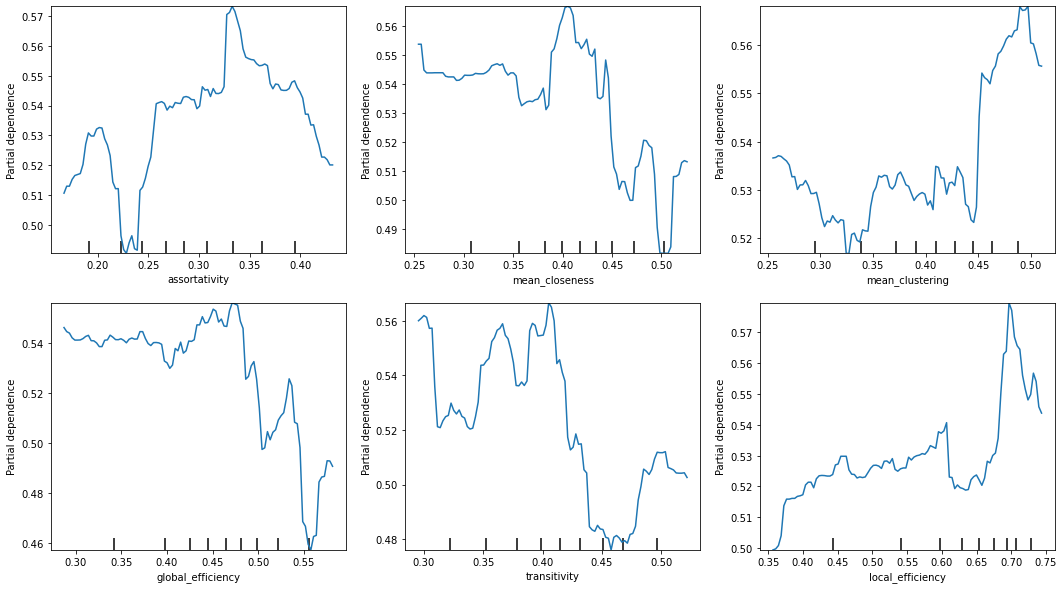

In [254]:
fig, axs = plt.subplots(2,3, figsize = (18,10))  
for i in range(6):
    plot_partial_dependence(randomf, X, [i], ax = axs[i//3,i%3]) 

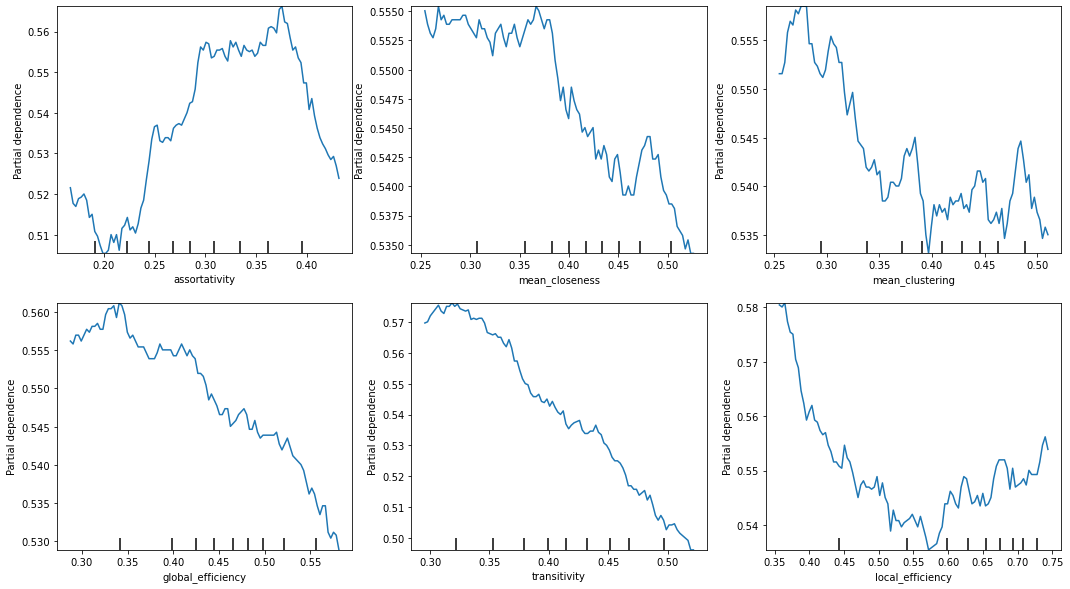

In [255]:
fig, axs = plt.subplots(2,3, figsize = (18,10))  
for i in range(6):
    plot_partial_dependence(knn, X, [i], ax = axs[i//3,i%3]) 

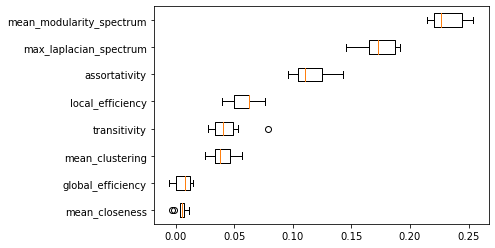

In [264]:
result = permutation_importance(knn, X, classes, n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()
plt.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=X.columns[perm_sorted_idx]);

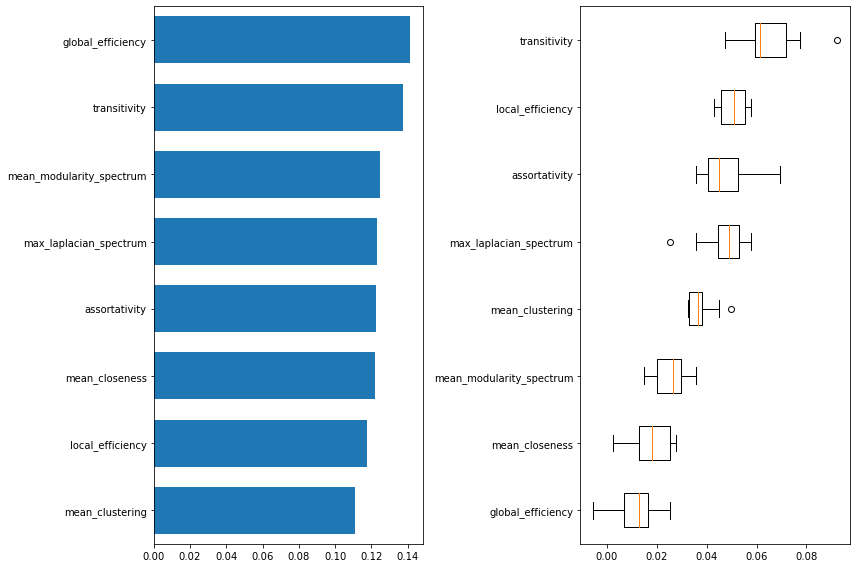

In [268]:
result = permutation_importance(randomf, X, classes, n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(randomf.feature_importances_)
tree_indices = np.arange(0, len(randomf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         randomf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(X.columns[tree_importance_sorted_idx])
ax1.set_ylim((0, len(randomf.feature_importances_)))
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=X.columns[perm_sorted_idx])
fig.tight_layout()

## Node centered features
Посмотрим признаки на нодах, возьмем node strength отдельно для положительных и отрицательных, а остальные для модуля графа, оставим 10% весов

In [289]:
level = np.percentile(np.abs(conn_abide['correlation'])[:], 90)
wadj = vec_to_sym(np.abs(conn_abide['correlation']))
wadj[wadj<level]=0

In [406]:
conn_abide['correlation'][:2,:].shape

(2, 34716)

In [413]:
local_graph_attr = {
              'betw_centr': lambda x: nx.betweenness_centrality(x, weight='weight'),
              'clust': lambda x: nx.clustering(x, weight = 'weight')
            }

def compute_local_measures(flat_vec, graph_attr, threshold = 0.05):
    """
    compute global graph metrics by flatten vector
    
    Args:
        flat_vec (numpy nd.array): array with connectivity weights 
        threshold (float): share of connections to left, default 0.1, (try 0.5, 0.15)
        corr_left (string):  type of correlation could be 'positive', 'negative' or 'both' only positive, only negative or absolute value
    Return:
        pandas dataframe with all characteristics
    """
    #print('Computing node strength \n')
    full_matrixes = vec_to_sym(flat_vec)
    level = np.percentile(np.abs(flat_vec[:]),100*(1-threshold))
    colnames = []
    node_features = []   
    pos_name = ['pos_strength_'+ v for v in map(str,range(264))]
    neg_name = ['neg_strength_'+ v for v in map(str,range(264))]
    nx_names = []
    [nx_names.extend([key+v for v in map(str,range(264))]) for key in graph_attr.keys()]
    columns = pos_name+neg_name+nx_names
    for i in tqdm(range(flat_vec.shape[0])):
        node_strength = compute_node_strength(full_matrixes[i])
        wadj = np.abs(full_matrixes[i])
        wadj[wadj<level]=0
        G = nx.from_numpy_array(wadj)
        node_nx_features = []
        for key, func in graph_attr.items():
            key_list = list(func(G).values())
            node_nx_features.extend(key_list)
        node_features.append(np.hstack([node_strength,node_nx_features]))        
        
        
    df = pd.DataFrame(node_features, columns = columns)
    df.to_csv('LocalNetworksMeasures.csv', index=False)
    return df


def compute_node_strength(sym_matrix):
    positive_edges = np.clip(sym_matrix, 0, sym_matrix.max())
    negative_edges = np.clip(sym_matrix, sym_matrix.min(), 0)
    node_strength_positive = np.sum(np.abs(positive_edges), axis=0)
    node_strength_positive /= np.max(node_strength_positive)
    node_strength_negative = np.sum(np.abs(negative_edges), axis=0)
    node_strength_negative /= np.max(node_strength_negative)
    return np.hstack([node_strength_positive , node_strength_negative])


In [416]:
df_local = compute_local_measures(conn_abide['correlation'], local_graph_attr, threshold = 0.1)

100%|██████████| 866/866 [17:18<00:00,  1.20s/it]


In [423]:
df_local.head()

,pos_strength_0,pos_strength_1,pos_strength_2,pos_strength_3,pos_strength_4,pos_strength_5,pos_strength_6,pos_strength_7,pos_strength_8,pos_strength_9,...,clust254,clust255,clust256,clust257,clust258,clust259,clust260,clust261,clust262,clust263
0,0.298105,0.358630,0.396668,0.294786,0.431760,0.178051,0.517272,0.515869,0.353856,0.334086,...,0.166998,0.187946,0.107708,0.129586,0.097165,0.165530,0.090143,0.209626,0.161735,0.131414
1,0.433299,0.627291,0.412601,0.419628,0.459170,0.469782,0.438011,0.464718,0.707639,0.488026,...,0.267072,0.174105,0.122556,0.266840,0.186991,0.237273,0.276938,0.191911,0.182709,0.203631
2,0.334351,0.473201,0.431625,0.513937,0.431883,0.649587,0.422071,0.558493,0.513690,0.258290,...,0.099073,0.121976,0.135024,0.173461,0.152623,0.296056,0.157880,0.152576,0.114978,0.160292
3,0.633450,0.578351,0.535879,0.389389,0.425505,0.390668,0.366579,0.450546,0.659783,0.381806,...,0.205710,0.130064,0.000000,0.138058,0.197921,0.206480,0.134028,0.206031,0.053861,0.119520
4,0.502143,0.418932,0.682126,0.512348,0.541020,0.558872,0.605199,0.396409,0.686616,0.299069,...,0.217440,0.284670,0.252783,0.189454,0.193312,0.130772,0.134317,0.154841,0.262538,0.195638


In [561]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [568]:
pipe_logreg = Pipeline([('scale', StandardScaler()), ('reducer',  PCA(n_components=600)),
                 ('clf', LogisticRegression(penalty='l2', C=1, solver='lbfgs', max_iter=600, random_state=0))])

In [569]:
cv = StratifiedShuffleSplit(n_splits=2, test_size=0.25,
                            random_state=0)
iter_for_prediction = cv.split(np.zeros(classes.shape[0]), classes)
train_index, test_index = next(iter_for_prediction)
Xtrain = np.hstack([df_local.values[train_index,:], conn_abide['correlation'][train_index]])
pipe_logreg.fit(Xtrain, classes[train_index])

Pipeline(steps=[('scale', StandardScaler()), ('reducer', PCA(n_components=600)),
                ('clf', LogisticRegression(C=1, max_iter=600, random_state=0))])

In [570]:
Xtest = np.hstack([df_local.values[test_index,:], conn_abide['correlation'][test_index]])

pipe_logreg.score(Xtest, classes[test_index])

0.6359447004608295

In [534]:
df_local.values[train_index,:].shape

(649, 1056)

In [543]:
#np.abs(logreg_weights.coef_.flatten())>0.1

In [550]:
conn_abide['correlation'][:,np.abs(logreg_weights.coef_.flatten())>0.1][train_index].shape

(649, 389)

In [551]:
Xtrain = np.hstack([df_local.values[train_index,:], conn_abide['correlation'][:,np.abs(logreg_weights.coef_.flatten())>0.1][train_index]])

In [572]:
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25)
iter_for_prediction = cv.split(np.zeros(classes.shape[0]), classes)
logreg_weights = LogisticRegression(penalty='l2', C=10, solver='lbfgs', max_iter=400, random_state=0)
pipe_logreg = Pipeline([('scale', StandardScaler()), ('reducer',  PCA(n_components=600)),
                 ('clf', LogisticRegression(penalty='l2', C=1, solver='lbfgs', max_iter=600, random_state=0))])

for index, (train_index, test_index) in enumerate(iter_for_prediction):
    print(f"[Cross-validation] Running fold: {index}")
    logreg_weights.fit(conn_abide['correlation'][train_index,:], classes[train_index])
    print(f"Quality based on weights {logreg_weights.score(conn_abide['correlation'][test_index,:], classes[test_index]):.2f}")
    pipe_logreg.fit(df_local.values[train_index,:], classes[train_index])
    print(f"Quality based on nx {pipe_logreg.score(df_local.values[test_index,:], classes[test_index]):.2f}")
   
    Xtrain = np.hstack([df_local.values[train_index,:], conn_abide['correlation'][train_index]])
    Xtest = np.hstack([df_local.values[test_index,:], conn_abide['correlation'][test_index]])
    pipe_logreg.fit(Xtrain, classes[train_index])
    print(f"Quality based on weights+nx {pipe_logreg.score(Xtest, classes[test_index]):.2f}")


[Cross-validation] Running fold: 0
Quality based on weights 0.59
Quality based on nx 0.48
Quality based on weights+nx 0.59
[Cross-validation] Running fold: 1
Quality based on weights 0.68
Quality based on nx 0.55
Quality based on weights+nx 0.64
[Cross-validation] Running fold: 2
Quality based on weights 0.67
Quality based on nx 0.56
Quality based on weights+nx 0.67
[Cross-validation] Running fold: 3
Quality based on weights 0.65
Quality based on nx 0.53
Quality based on weights+nx 0.62
[Cross-validation] Running fold: 4
Quality based on weights 0.62
Quality based on nx 0.52
Quality based on weights+nx 0.60
[Cross-validation] Running fold: 5
Quality based on weights 0.63
Quality based on nx 0.59
Quality based on weights+nx 0.66
[Cross-validation] Running fold: 6
Quality based on weights 0.66
Quality based on nx 0.53
Quality based on weights+nx 0.64
[Cross-validation] Running fold: 7
Quality based on weights 0.60
Quality based on nx 0.48
Quality based on weights+nx 0.60
[Cross-validatio